In [ ]:
from typing import List, Dict, Any, TypedDict
from pm_market_getter import get_markets_for_date_range
from langchain.llms import OpenAI
from langchain.tools import Tool
from langchain.agents import AgentExecutor, OpenAIFunctionsAgent
from langchain.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel, Field
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolInvocation
from operator import add
from typing import Annotated
from datetime import datetime, timedelta
from langgraph.prebuilt import ToolExecutor
import requests
import json
import re
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import operator
from typing import  Annotated
from langgraph.constants import Send
import threading

C:\Users\Ethan.Goldberg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
class Counter:
    def __init__(self):
        self._lock = threading.Lock()
        self._value = 0
    
    def get_next(self):
        with self._lock:
            self._value += 1
            return self._value

# Global counter instance
article_counter = Counter() 

class NewsArticles(BaseModel):
    title: str
    description: str
    source_name: str
class ArticleOutput(BaseModel):
    id: int = Field(default_factory=article_counter.get_next)
    headline: str
    subheader: str
    blurb: str = Field(default=None)
    score: int = Field(default=None)
    ticker: str = Field(default=None)
    links: List[str] = Field(default=None)

class MarketInfo(BaseModel):
    interest_score: float = Field(default=None)
    title: str = Field(default=None)
    ticker: str = Field(default=None)
    description: str = Field(default=None)
    end_date: str = Field(default=None)
    volume: float = Field(default=None)
    featured: float = Field(default=None)
    volume24hr: float = Field(default=None)
    commentCount: float = Field(default=None)
    options: List[Dict[str, Any]] = Field(default=None)
    tags: List[Dict[str, Any]] = Field(default=None)
    tavily_context: Annotated[list, operator.add] = Field(default=None)
    links: Annotated[list, operator.add] = Field(default=None)
    articles: List[NewsArticles] = Field(default_factory=list, description="Collected news articles")
    newsletter_content: List[ArticleOutput] = Field(default=None)

class OverallGraph(BaseModel):
    markets_list: List[MarketInfo]
    newsletter_content: Annotated[List[ArticleOutput], operator.add] = Field(default=None)
    article_groups: Dict[str, List[int]] = Field(
        default_factory=dict,
        description="Dictionary of lists, where each list contains ids of a group of articles. The string is the title of the group"
    )
    done: bool = Field(default = False)

class ExperimentState(TypedDict):
    market: dict  # The current market being processed
    article: dict  # The article being generated/refined
    previous_articles: List[dict]  # List of previously processed articles
    keep_article: bool

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [3]:
from dotenv import load_dotenv
import os
load_dotenv()
news_api_key = os.getenv('NEWS_API_KEY')
openai_api = os.getenv('OPENAI_API_KEY')
tavily_api_key = os.getenv('TAVILY_API_KEY')
smtp_pass = os.getenv('SMTP_PASS')

In [4]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
def generate_news_query(title, description) -> str:
    llm = ChatOpenAI(model="gpt-4o-mini", api_key = openai_api)  # You can use a different model if preferred
    
    prompt = f"""
    You are an expert in information retrieval and natural language processing. Your task is to analyze the title and description of a prediction market and generate optimal keywords for a news API search. These keywords should maximize the retrieval of relevant and informative news articles about the market's subject.

    Given:
    - Title: {title}
    - Description: {description}

    Instructions:
    1. Carefully read and understand the title and description.
    2. Identify the core subject matter, key entities, and central concepts.
    3. Consider potential synonyms, related terms, and broader categories that might yield relevant results.
    4. Avoid overly generic terms that might lead to irrelevant results.
    5. Include any specific dates, events, or proper nouns mentioned that are crucial to the market.
    6. Consider the timeframe of the prediction, if specified, and how it might affect keyword relevance.
    7. Aim for a balance between specificity (to ensure relevance) and breadth (to capture a range of potentially useful articles).
    8. Generate 1-3 keyword phrases, separated by commas if more than one.
    9. Each keyword should always be ONE word. There are exceptions for when two or three words are closely linked like "Donald Trump" is two words but would be allowed.

    Output your result in the following format. DO NOT say any other words or give any other explanation.
    Keywords: [Your generated keywords]
    """
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    # Extract keywords from the response
    keywords_line = [line for line in response.content.split('\n') if line.startswith('Keywords:')][0]
    keywords = keywords_line.split(':', 1)[1].strip()
    keywords_array = [item.strip() for item in keywords.split(',')]
    return keywords_array

In [5]:
os.environ["TAVILY_API_KEY"] = tavily_api_key
tavily_getter = TavilySearchResults(max_results=5)

In [6]:
def tavily_search(state: MarketInfo):
    llm = ChatOpenAI(model="gpt-4o-mini", api_key = openai_api)
    search_instructions = """You will be given the title, description, and end_date for a polymarket prediction market. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the market to provide context to the market. For example, there may be a market on whether Taylor Swift gets married in 2024. A good search query might be "Taylor Swift Pregnancy Rumors 2024".
        
First, analyze the market.

Pay particular attention to the title, description, and dates for the market.

Convert this final question into a well-structured web search query that will give important context to understand it.

Title : {title}          

Description : {description}

End Date : {end_date}
                                        """
    structured_llm = llm.with_structured_output(SearchQuery)
    system_message = search_instructions.format(title=state.title, description=state.description, end_date = state.end_date)
    search_query = structured_llm.invoke([SystemMessage(content=system_message)])

    # search_docs = tavily_getter.invoke(search_query.search_query)
    search_docs = [{"url": "nothing.com", "content": "no content"}]

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    links = [doc["url"] for doc in search_docs]

    return {"tavily_context": [formatted_search_docs],
            "links": links} 


In [7]:
def call_news_api(state: MarketInfo) -> MarketInfo:
    keywords = generate_news_query(state.title, state.description)
    print(keywords)
    today = datetime.now().date()
    from_date = (today - timedelta(days=3)).isoformat()
    to_date = today.isoformat()
    url = "https://newsapi.org/v2/everything"
    for keyword in keywords:
        params = {
            "from": from_date,
            "to": to_date,
            "apiKey": news_api_key,
            "country" : "us",
            "q" : keyword,
            "pageSize" : 2
        }
        response = requests.get(url, params=params)
        data = response.json()
        articles = data.get("articles", [])
        for article in articles:
            article_info =  NewsArticles(
            title=article['title'],
            description=article['description'],
            source_name=article['source']['name']
        )
            state.articles.append(article_info)

    return state    


In [8]:
class market_key_info(BaseModel):
    what_is_the_market_asking_or_answering: str = Field(defualt=None, description= "this should be a synposis of what this market is asking or answering")
    important_criteria: List[str] = Field(default_factory=List, description="a list of strings that describe important critera for a market and how it is resolved. includes timeline")
    completed: bool = Field(default=None, description="boolean indicating whether or not a market is essentially resolved. If the probability of all the options adds up to 0 or if the probability of any of the options is about 100, it is essentially guaranteed to already have happened or will happen")
    important_insights_context_or_reasoning : str = Field(default=None, description= "summary of important context or insights that could be related to this market. if there is important context from the sources from the internet regarding a probability or a change")

In [9]:
class article_score(BaseModel):
    score: int = Field(default=5, descrption="score for the article 0-10")

In [10]:
def generate_newsletter_content(market: MarketInfo) -> OverallGraph:
    market_dict = market.dict(exclude={'articles', 'final_answer', 'featured','commentCount', 'interest_score', 'newsletter_content', 'tavily_context'})
    context = market.tavily_context
    llm = ChatOpenAI(model="gpt-4o-mini", api_key = openai_api)
    intermediate_model = llm.with_structured_output(market_key_info)
    prompt = f"""
    It's great to finally meet you. You are my expert research analyst for my VC fund, specializing in reading and contextualizing prediciton markets. Be objective and precise. Be formal and exact. Your job is to take a structured api output from a prediction market and results from the internet for context on that market and: draw out the specific insights to later be used to create a news article. You should write in your output eveyrthing I need to draw from the market that is interesting.
    Here is the model you will be outputting:
    what_is_the_market_asking_or_answering: str = Field(defualt=None, description= "this should be a synposis of what this market is asking or answering")
    important_criteria: List[str] = Field(default_factory=List, description="a list of strings that describe important critera for a market and how it is resolved. includes timeline")
    completed: bool = Field(default=None, description="boolean indicating whether or not a market is essentially resolved. If the probability of all the options adds up to 0 or if the probability of any of the options is about 100, it is essentially guaranteed to already have happened or will happen")
    important_insights_context_or_reasoning : str = Field(default=None, description= "summary of important context or insights that could be related to this market. if there is important context from the sources from the internet regarding a probability or a change")

    The market_dict is a dictionary containing the following key information:
    - title: The title of the Polymarket prediction market
    - description: A description of the market
    - end_date: The resolution date for the market (pay close attention to this)
    - tags: Relevant tags for the market
    - options: A list of dictionaries, each containing:
      - 'outcome': The possible outcome
      - 'probability': The likelihood of the outcome (in decimal form, e.g., 0.75 = 75%)
      - 'oneDayPriceChange': How much the probability has changed in the last day

    The context variable is a list of sources and information from the internet.

    Here is the market to take to produce these insights:
    {market_dict}

    And here are the articles from the internet:

    {context}


    Remember to format your insights as described and be sure not to miss anything important. Be as compelling and interesting as possible.

    """
    response = intermediate_model.invoke([HumanMessage(content=prompt)])
    
    response_dict = response.dict()

    print("this is the intermediate reseponse: ", response_dict)
    
      # You can use a different model if preferred
    
    # Create a dict of the market model, omitting the articles
    
    prompt = f"""
You are a savvy AI newsletter writer specializing in prediction markets and current events. Your task is to generate compelling newsletter content based on Polymarket prediction markets and potentially related search context. Your writing should be engaging, insightful, and highlight the fascinating world of prediction markets, using context where applicable. Your audience is  intelligent and have signed up for your newsletter because they believe that prediction markets unlock information about the world and about the news.

The market_dict is a dictionary containing the following key information:
- title: The title of the Polymarket prediction market
- description: A description of the market
- end_date: The resolution date for the market (pay close attention to this)
- tags: Relevant tags for the market
- options: A list of dictionaries, each containing:
  - 'outcome': The possible outcome
  - 'probability': The likelihood of the outcome (in decimal form, e.g., 0.75 = 75%)
  - 'oneDayPriceChange': How much the probability has changed in the last day


You will get the following curated info about the market:
    what_is_the_market_asking_or_answering: str = Field(defualt=None, description= "this should be a synposis of what this market is asking or answering")
    important_criteria: List[str] = Field(default_factory=List, description="a list of strings that describe important critera for a market and how it is resolved. includes timeline")
    completed: bool = Field(default=None, description="boolean indicating whether or not a market is essentially resolved. If the probability of all the options adds up to 0 or if the probability of any of the options is about 100, it is essentially guaranteed to already have happened or will happen")
    important_insights_context_or_reasoning : str = Field(default=None, description= "summary of important context or insights that could be related to this market. if there is important context from the sources from the internet regarding a probability or a change")


Lastly, you will get information from the internet. This should be used as supplemental information and context as to the cause of certain odds, and when used in the article, should be cited.

Note: The interesting part of the market and how it relates to narratives on the internet might not need all of the provided information. Use your judgment to determine the applicability of information.

Instructions:
1. Carefully analyze the Polymarket prediction market information, paying special attention to the end_date and time frame criteria specified in the title or description.
2. Review the related context provided by searching the web, identifying any relevant information to the market. If no links are relevant, focus solely on the market data.
3. Identify the most interesting or surprising aspects of the market probabilities, potentially contrasting them with relevant news reporting if applicable.
4. Create a catchy headline that captures attention by highlighting these interesting aspects, ensuring it accurately reflects the time frame of the market.
5. Write a subheader that provides additional context or intrigue.
6. Compose a brief, engaging blurb that expands on the headline and subheader, incorporating relevant information from the prediction market and, if applicable, the web.

These are notes from an expert newsletter author on writing headlines that you should ABSOLUTELY use to make your headlines.
1. Write short and sweet sentences. Use as few words as possible to convey all the information you need.
2. Write in positive form. (Example:
Dont write: Jonas didnt win the election.
Instead write: Jonas lost the election.
3. Be active in your sentences not passive.
4. Do not use slang.
5. Use present tense and do not use articles (a, an, the)

Your output should follow this format:
**Headline:** Your attention-grabbing headline
**Subheader:** A supporting subheader that adds context
**Blurb:** A 2-3 sentence paragraph expanding on the headline and subheader

Ensure that you use the exact formatting with the bold markers (**) as shown above.

Now, using the provided market_dict and articles, generate a compelling newsletter section following the format above. Remember to focus on the most intriguing aspects of the prediction market, potentially contrasting with news reports if relevant. Craft a headline that captures attention and sparks curiosity, always ensuring your content accurately reflects the time frame specified in the market. If the provided web searches aren't relevant, feel free to focus solely on the fascinating world of the prediction market itself. Keep in mind, that you are going to be asked to do many of these articles in a row, so make your wording unique so you do not repeat phrasings.

Input Market Info:
{market_dict}

Important market analysis to utilize:
{response_dict}

Input Context from Web:
{context}
"""
    better_llm = ChatOpenAI(model="gpt-4o", api_key = openai_api)
    structured_llm_better = better_llm.with_structured_output(ArticleOutput)
    response = structured_llm_better.invoke([HumanMessage(content=prompt)])
    print("this is the stuctured article output: ", response.dict())

    system_prompt = f"""You are an expert editor evaluating newsletter content that combines traditional news with prediction market insights from Polymarket. You'll score submissions from 0-10 based on three key criteria:

1. Insight Value (0-10):
   - Does it reveal non-obvious implications using prediction market data?
   - Does it connect market probabilities to real-world implications?
   - Does it go beyond surface-level news reporting?

2. Information Quality (0-10):
   - Is the information specific and actionable?
   - Are market probabilities clearly connected to conclusions?
   - Does it avoid vague or generic statements?

3. Professionalism & Tone (0-10):
   - Is the content respectful and professional?
   - Does it maintain appropriate formality when discussing serious topics?
   - Does it avoid sensationalism while remaining engaging?

The final score is the average of these three scores, rounded to the nearest integer.

Here are examples of different quality levels:

SCORE 10 EXAMPLE:
Headline: "Market Signals 75% Chance of Fed Rate Pause Through Q2"
Subheader: "Traders Betting Heavily on Extended Hold Pattern Despite Recent Inflation Data"
Blurb: "While mainstream coverage focuses on the latest CPI print, Polymarket's fed-futures contract reveals traders are increasingly confident about an extended rate pause. The 75% probability suggests markets have largely priced in stabilizing inflation, despite mixed economic signals. This diverges from traditional analyst forecasts, which remain split on the Fed's next move. For investors, this implies potential opportunities in rate-sensitive sectors that may be mispriced based on mainstream narratives."

Analysis:
- Insight Value: 10/10 - Combines market data with practical investment implications
- Information Quality: 10/10 - Specific probabilities and actionable insights
- Professionalism: 10/10 - Maintains formal tone while being engaging
Total Score: 10/10

SCORE 5 EXAMPLE:
Headline: "Ukraine Aid Package Shows 60% Chance of Passage"
Subheader: "Market Odds Reflect Congressional Uncertainty"
Blurb: "Polymarket traders are giving the latest Ukraine aid package a 60% chance of passing this month. This matches the general consensus from political analysts, though doesn't provide much additional insight. The market has fluctuated between 55-65% over the past week, suggesting no clear direction yet."

Analysis:
- Insight Value: 4/10 - Mostly restates known information
- Information Quality: 6/10 - Clear probabilities but limited analysis
- Professionalism: 5/10 - Adequate but could provide more context
Total Score: 5/10

SCORE 0 EXAMPLE:
Headline: "Markets Predict Chaos in Upcoming Election!!!"
Subheader: "Traders Betting Big on Political Drama"
Blurb: "Election markets are going crazy right now! Some traders are betting everything will fall apart, while others think it'll be fine. Numbers are all over the place. Could be really bad news for everyone if things go wrong!!!"

Analysis:
- Insight Value: 0/10 - No specific insights or analysis
- Information Quality: 0/10 - Vague statements without data
- Professionalism: 0/10 - Sensationalist and unprofessional tone
Total Score: 0/10

Please evaluate the following content and provide a single integer score from 0-10, reflecting the average of the three criteria rounded to the nearest integer. Format your response as JSON with a single key 'score' and an integer value.

Content to evaluate: 
Headline: {response.headline}
Subheader: {response.subheader}
Blurb: {response.blurb}
"""
    score_llm = llm.with_structured_output(article_score)
    score_response = score_llm.invoke([HumanMessage(content=system_prompt)])

    print("returning article with headline: ", response.headline)
    return {"newsletter_content" : [ArticleOutput(
            headline=response.headline,
            subheader=response.subheader,
            blurb=response.blurb,
            score=score_response.score,
            ticker = market.ticker,
            links = market.links
        )]}

In [11]:
def continue_to_markets(state: OverallGraph):
    return [Send("parallel_article_writing", market) for market in state.markets_list]

In [12]:
class ArticleGroups(BaseModel):
    article_groups: Dict[str, List[int]] = Field(
        default_factory=dict,
        description="Dictionary of lists, where each list contains ids of a group of articles. The string is the title of the group"
    )

In [13]:
def enumerate_articles(articles):
    return "\n".join(f"{article}" for article in articles)

def generate_groups(state: OverallGraph):
    llm = ChatOpenAI(model="gpt-4", api_key=openai_api)  # Fixed model name
    structured_llm = llm.with_structured_output(ArticleGroups)
    
    formatted_articles = "\n".join([
        f"ID {article.id}: {article.headline}" 
        for article in state.newsletter_content
    ])
    
    prompt = f"""You are tasked with grouping news articles into categories. Create categories that contain 2-5 related articles each.

For each article, use ONLY the ID number shown at the start of each line.

Example output format:
{{
    "article_groups": {{
        "Middle East": [21, 4, 26],
        "Cryptocurrency": [7, 9, 15],
        "Sports": [13, 19, 18]
    }}
}}

Here are the articles to categorize:

{formatted_articles}

Group these articles into appropriate categories, ensuring each article ID is used exactly once and each category has at least 2 articles."""
    
    try:
        result = structured_llm.invoke([SystemMessage(content=prompt)])
        print("Structured output:", result)
        return {"article_groups": result.article_groups}
    except Exception as e:
        print(f"Error generating groups: {e}")
        return {"article_groups": {}}
def send_redundant_groups(state : OverallGraph):
    if state.done == True:
        print("ending")
        print("state before ending: ", state)
        return END
    list_of_lists_of_articles =[]
    for redundant_group in state.redundant_groups:
        articles_idx_individual = [state.newsletter_content[index] for index in redundant_group]
        list_of_lists_of_articles.append(articles_idx_individual)
    return [Send("combine_articles", articles) for articles in list_of_lists_of_articles]
def combine_articles(articles):
    print('fixing this redundant group')
    llm = ChatOpenAI(model="gpt-4o-mini", api_key = openai_api) 
    structured_llm = llm.with_structured_output(ArticleOutput)
    prompt = f"""
    You are a skilled AI editor tasked with condensing multiple prediction market newsletter articles into a single, comprehensive article. Your goal is to distill the most crucial information from each input article while maintaining the engaging style and format of the original pieces.
    Input:
    You will receive a list of newsletter articles, each following this structure:
    Headline: [Attention-grabbing headline]
    Subheader: [Supporting subheader adding context]
    Blurb: [2-3 sentence paragraph expanding on the headline and subheader]
    Instructions:

    Analyze all input articles, identifying the most significant and intriguing information from each.
    Create a new, overarching headline that captures the essence of the combined articles.
    Craft a subheader that provides additional context for the main headline.
    Write a concise blurb that synthesizes the key points from all input articles. This blurb should:

    Highlight the most interesting prediction market probabilities and movements.
    Mention any relevant time frames or end dates for the markets.
    Include any notable contrasts with traditional news reporting, if applicable.
    Preserve the confident, slightly irreverent tone of the original articles.


    Ensure your writing is engaging and assumes an audience familiar with prediction markets.
    Be as concise as possible while encoding the maximum amount of relevant information.

    Your output should follow this format:
    Headline: [Your new, overarching headline]
    Subheader: [A supporting subheader that adds context]
    Blurb: [A 3-4 sentence paragraph synthesizing key information from all input articles]
    Remember to use the exact formatting with the bold markers (**) as shown above.
    Now, using the provided input articles, generate a single, comprehensive newsletter article that captures the most crucial information while maintaining the engaging style and format of the original pieces.
    Here are the articles:
    {articles}"""
    response = structured_llm.invoke([SystemMessage(content=prompt)])
    print("made this new article out of ", len(articles), " articles with the headline: ", response.headline)
     
    return {"newsletter_content" : [ArticleOutput(
            headline=response.headline,
            subheader=response.subheader,
            blurb=response.blurb
        )]}
def remove_redundants(state: OverallGraph):
    print("removing redundants")
    flat_indices = set([index for sublist in state.redundant_groups for index in sublist])
    # Remove items from each sublist
    state.newsletter_content = [item for i, item in enumerate(state.newsletter_content) if i not in flat_indices]
    return state

In [14]:
def check_if_done(state : OverallGraph):
    if state.done == True:
        return END
    else:
        return 'combine_similar'

In [15]:
# Define the graph
from IPython.display import Image, display
def define_workflow():
    workflow = StateGraph(MarketInfo)
    
    workflow.add_node("get_context", tavily_search)
    workflow.add_node("generate_newsletter", generate_newsletter_content)
    
    workflow.set_entry_point("get_context")
    workflow.add_edge("get_context", "generate_newsletter")
    workflow.add_edge("generate_newsletter", END)

    parallel_workflow = StateGraph(OverallGraph)

    parallel_workflow.add_node("parallel_article_writing", workflow.compile())
    parallel_workflow.set_conditional_entry_point(continue_to_markets, ["parallel_article_writing"])
    parallel_workflow.add_node("generate_groups", generate_groups)
    parallel_workflow.add_edge("parallel_article_writing", "generate_groups")
    # parallel_workflow.add_node("combine_articles", combine_articles)
    # parallel_workflow.add_conditional_edges("generate_groups", send_redundant_groups, ["combine_articles", END])
    # parallel_workflow.add_node("remove_redundants", remove_redundants)
    # parallel_workflow.add_edge("combine_articles", "remove_redundants")
    parallel_workflow.add_edge("generate_groups", END)
    react_graph = parallel_workflow.compile()
    


    

    # Show
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
    
    return react_graph

In [16]:
def articles_wrapper(days_in_past):
    market_info_list = []
    graph = define_workflow()
    articles = []
    full_info = []
    markets = get_markets_for_date_range(days_in_past=days_in_past, limit=50)
    print("len of markets pre score cutoff: ", len(markets))
    sorted_markets_by_interest = sorted(
    {market['title']: market for market in markets if market.get('interest_score', 0) > 1200}.values(),
    key=lambda x: x.get('interest_score', 0),
    reverse=True
)
    print("len of markets post score cutoff: ", len(sorted_markets_by_interest))
    for market in sorted_markets_by_interest:
        market_info_example = MarketInfo(**market)
        # market_end_result = app.invoke(market_info_example)
        market_info_list.append(market_info_example)
        # if market_end_result['newsletter_content']:
        #     articles.append(market_end_result['newsletter_content'])
        #     full_info.append(market_end_result)
    print("number of markets going into the graph: ",len(market_info_list))
    markets_model = OverallGraph(markets_list=market_info_list)
    result = graph.invoke(markets_model)
    
    return result

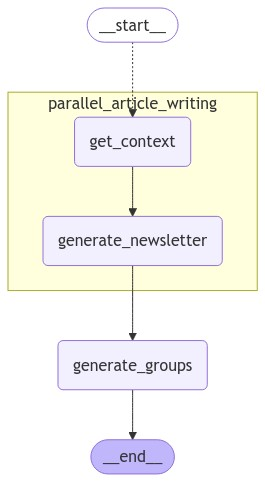

len of markets pre score cutoff:  184
len of markets post score cutoff:  15
number of markets going into the graph:  15
this is the intermediate reseponse:  {'what_is_the_market_asking_or_answering': "This market is evaluating the likelihood that Bitcoin's price will exceed $68,000.01 on November 1, 2024, at noon ET, based on Binance's BTCUSDT closing prices.", 'important_criteria': ["The price must be verified using Binance's BTCUSDT closing price at the specified time and date.", "The market resolves to 'Yes' if the price is equal to or exceeds 68,000.01; otherwise, it resolves to 'No'.", 'The end date for resolution is November 1, 2024, at 12:00 PM ET.'], 'completed': False, 'important_insights_context_or_reasoning': "The market currently shows a high probability (94.5%) that Bitcoin will exceed $68,000.01 by the resolution date, indicating strong bullish sentiment among traders. The recent price movements and trading volume suggest a robust interest in Bitcoin's price trajectory. H

In [17]:
result = articles_wrapper(7)


In [18]:
result

{'markets_list': [MarketInfo(interest_score=348514.5148913321, title='Another Iran strike on Israel in 2024?', ticker='another-iran-strike-on-israel-in-2024', description='This market will resolve to "Yes" if Iran initiates a military action on Israeli soil, airspace, maritime territory or any official Israeli embassy or consulate between October 25, 12:00 PM ET and December 31, 2024, 11:59 PM ET. Otherwise, this market will resolve to "No".\n\nFor the purposes of this market, a "military action" will be considered to be any use of force executed by Iran on Israeli soil, airspace, maritime territory or any official Israeli embassy or consulate (e.g. if a weapons depot on Israeli soil is hit by an Iranian missile, this market will resolve to "Yes") that is officially acknowledged by the Iranian government or a consensus of credible reporting. This includes, but is not limited to, airstrikes, naval attacks, or ground invasions. Cyber attacks, sanctions, or diplomatic actions will not cou

In [19]:
articles = result["newsletter_content"]
email_list = ["ethanagoldberg@gmail.com"]
#email_list = ["ethanagoldberg@gmail.com", "vikmanocha@gmail.com", "jameswmarren@gmail.com"]
groups = result["article_groups"]

In [20]:
from newsletter_sender import NewsletterSender, test_smtp_connection
from typing import List
smtp_config = {
    "host": "smtp.gmail.com",
    "port": 587,
    "secure": False,
    "auth": {
        "user": "polynewsdailynewsletter@gmail.com",  # Your full Gmail address
        "pass": smtp_pass    # The 16-character app password you generated
    },
    "from": '"PolyNewsDaily Update" <polynewsdailynewsletter@gmail.com>'  # Use your Gmail address here too
}

In [21]:
if test_smtp_connection(smtp_config):
    print("Connection successful! Sending test newsletter...")
    
    # Create sender and send newsletter
    sender = NewsletterSender()
    results = sender.send_newsletter(smtp_config, email_list, articles, groups)

✅ SMTP connection successful!
Connection successful! Sending test newsletter...
Sending batch 1/1
Successfully sent to: ethanagoldberg@gmail.com
